# Homework 1 (Due Feb. 10, 2023 at Noon) 

Submit your solution notebook in your directory via github PR.

## Problem 1 (50 pts)

###  Fitting a Line using a Maximum Likelihood Estimator

Last week, you implcitly fitted straight lines with methods of moments estimators (i.e. sample mean and variance) and L-estimators (median and IQR). Generally though, we want some kind of uncertainty estimate for our models, and therefore M-estimators and maximum likelihood estimators in particular are useful.

Assume the scatter in our measurements (the residuals) is generated by a gaussian process i.e.:

>$ y_i = a x_i + b + r_i $

where $r_i$ is drawn from $N(0, \sigma)$. Here, $\sigma$ is the error the measurement induces.

To use an M-estimator/MLE, you have to specify the likelihood function. First, the probability $p(y_i|x_i, M(a, b), \sigma)$ that a particular point $y_i$ would be measured is just the normal distribution:

>$ p(y_i|x_i, M(a, b), \sigma) = N(y_i - M(x)|\sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( - \frac{(y_i - M(x_i))^2}{2 \sigma^2} \right) $.

Given what we discussed in class, we can write down the $\ln L$

>$ \ln L(a, b) = constant - \frac{1}{2 \sigma^2} \sum_{i=1}^N (y_i - M(x_i))^2 $

This is the expression that we now minimize with respect to $a$ and $b$ to find ML estimators for those parameters. 


And as we discussed in class, this is equivalent to minimizing the sum of the squares or a _least-squares method_.

## MLE with outliers

Let's apply the MLE to data with uncertainties where these uncertainties include outliers. 
I've defined a dataset below:

Your mission is to:

- write a function that computes the squared loss, and incorporates the uncertainties on the measurements, $dy$ (10 pts)
- Fit a line to the full sample by evaluating this likelihood on a grid of a, b (10 pts)
- Use sigma-clipping or an L-estimator for outlier rejection and fit a line to the data with outliers rejected (10 pts) and make a QQ plot of the residuals (10 pts)
- Define a new likelihood function that implements the Huber loss, also incorporating the measurement uncertainties $dy$ (10 pts)
- Fit a new line to all of the data (no outlier rejection) with the new Huber likelihod, except now use scipy.optimize.fmin instead of a grid search, and you know the drill by now - QQ plot of the residuals (10 pts)

Recommended reading: David Hogg, Jo Bovy, and Dustin Lang: "Data analysis recipes: Fitting a model to data", 2010: https://arxiv.org/abs/1008.4686

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize
import statsmodels.api as sm
from astroML.datasets import fetch_hogg2010test

# this just makes plots a bit easier on my laptop - disable as needed
%config InlineBackend.figure_format='retina'

#------------------------------------------------------------
# Get data: this includes outliers
data = fetch_hogg2010test()
x = data['x']
y = data['y']
dy = data['sigma_y']

Taking a quick peak at the data.

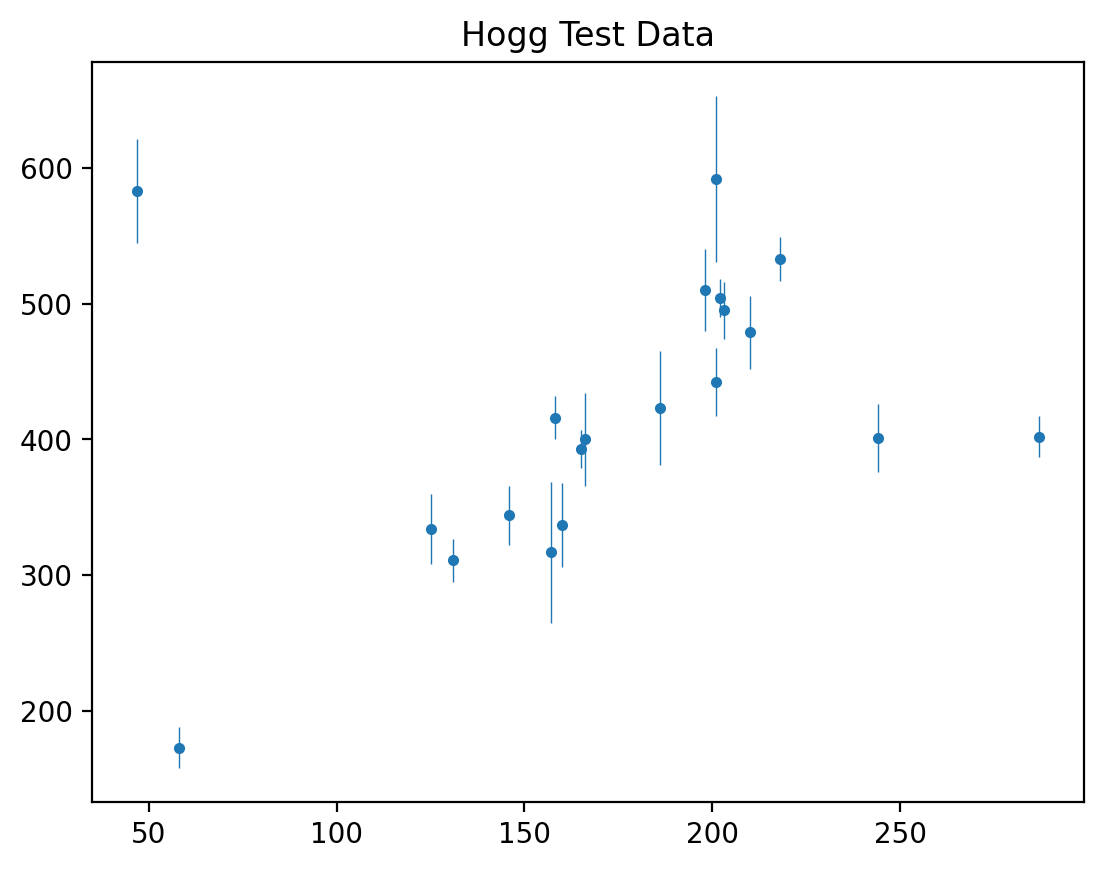

In [3]:
# quick look at the data
plt.title("Hogg Test Data")
plt.errorbar(x, y, yerr=dy, fmt='.', elinewidth=0.5)
plt.show()

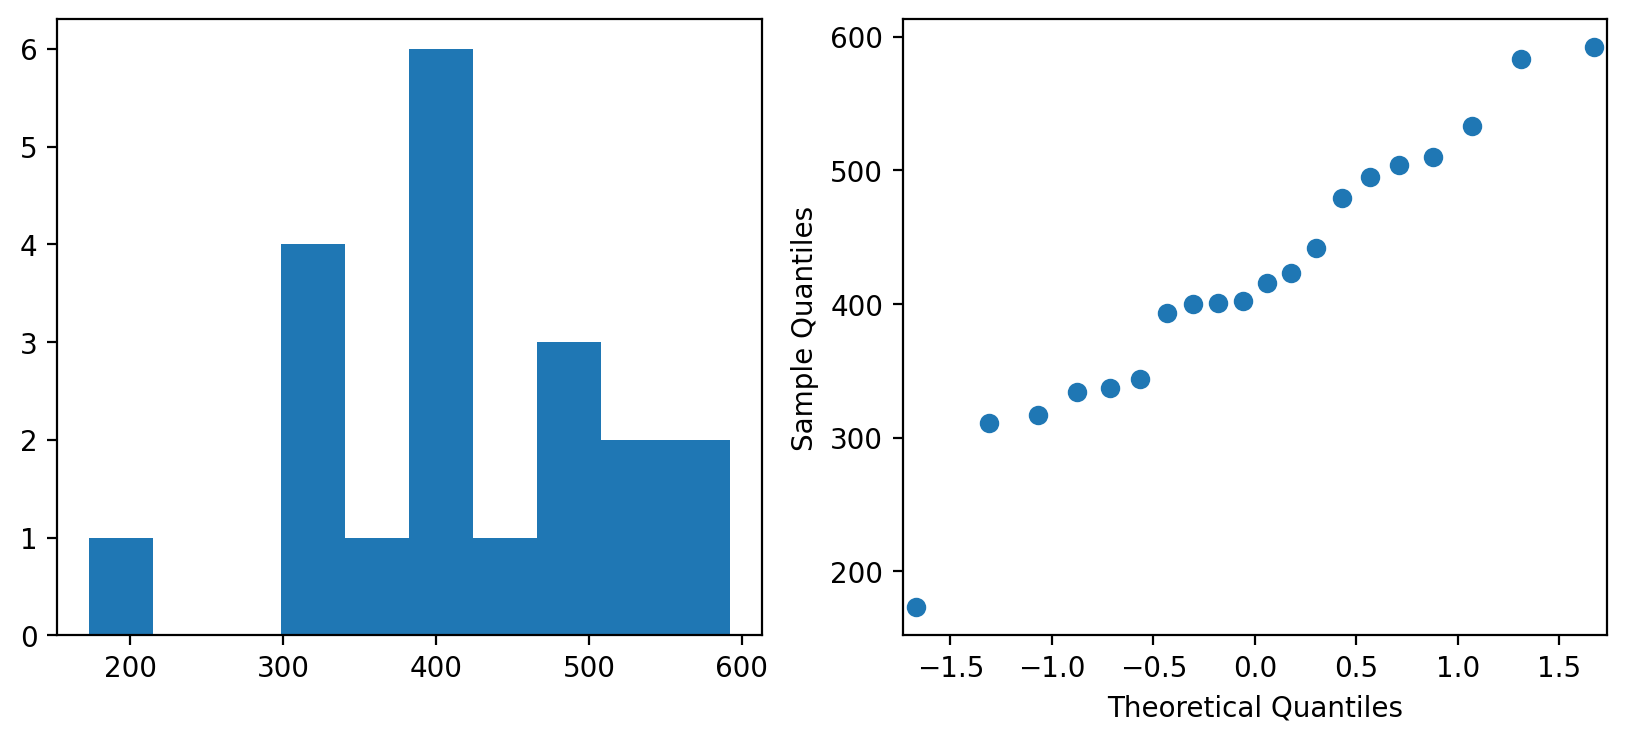

In [4]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
ax.hist(y) # gauss-ish?
ax2 = fig.add_subplot(122)
sm.qqplot(y,ax=ax2)
plt.show()

In this case, we want to minimize with respect to the model parameters, $a$ and $b$.

The simple cost function for this problem: $\rho(u) = u^2$, where $u = y_i - M(a,b,x_i)$, where $M(x_i)$ is our model for the data, which we are taking to be linear.

The squared loss is computed as follows: $\chi^2 = \sum_{i=1}^N \bigg(\frac{y_i - M(a,b,x_i)}{\sigma_i}\bigg)^2 = \sum_{i=1}^N \bigg(\frac{u}{\sigma_i}\bigg)^2 \sum_{i=1}^N \rho (u)\bigg(\frac{1}{\sigma_i}\bigg)^2$

In this case, $\sigma_i = dy_i$, so by dividing out $dy^2$ the uncertainties are incorperated as a weight to each cost.

In [5]:
# computing the chi squared/squared loss
def squared_loss(x,y,dy,model_params):
    
    (a,b) = model_params
    def model(a,b,x):
        return a*x + b
    
    M_x = model(a,b,x)
    return (((y - M_x) / dy)**2).sum()

Then, for some parameters of the line, we can find the maximum log likelihood, which is $\ln L \approx -\frac{\chi^2}{2}$

Now, a line can be fit to the data by finding $a,b$ that minimizes $\frac{\chi^2}{2}$. This will be done by selecting a range for both parameters and evalating the log likelihood:

Eyeballing the scatter plot above, I am going to guess $b = 75$ and $a = 1.5$, then probe values near this area.

In [6]:
def grid_search(x,y,dy,guess):
    (a_est, b_est) = guess
    grid_a, grid_b = np.mgrid[a_est*0.5:a_est*3:a_est/10, b_est*0.5:b_est*2:b_est/10] # chose an arbitrary range around my guess

    # make an empty matrix to hold points - each column is a (x,y) coord
    pos = np.empty(grid_a.shape + (2,)) # 3D matrix
    pos[:,:,0] = grid_a; pos[:,:,1] = grid_b

    min_ln_L = np.inf # largest possible value, so 1st value will reset this
    best_parameter = (0,0) # placeholder

    # loop through the points
    for i, row in enumerate(pos):
        for j, pt in enumerate(row):
            param_guess = (pt[0], pt[1]) # (a,b)

            # find the parameters that give the smallest -ln L = chi^2/2
            ln_L = squared_loss(x,y,dy,param_guess) / 2
            if ln_L < min_ln_L:
                min_ln_L = ln_L
                best_parameter = param_guess
                

    return best_parameter

Plotting this line onto the data:

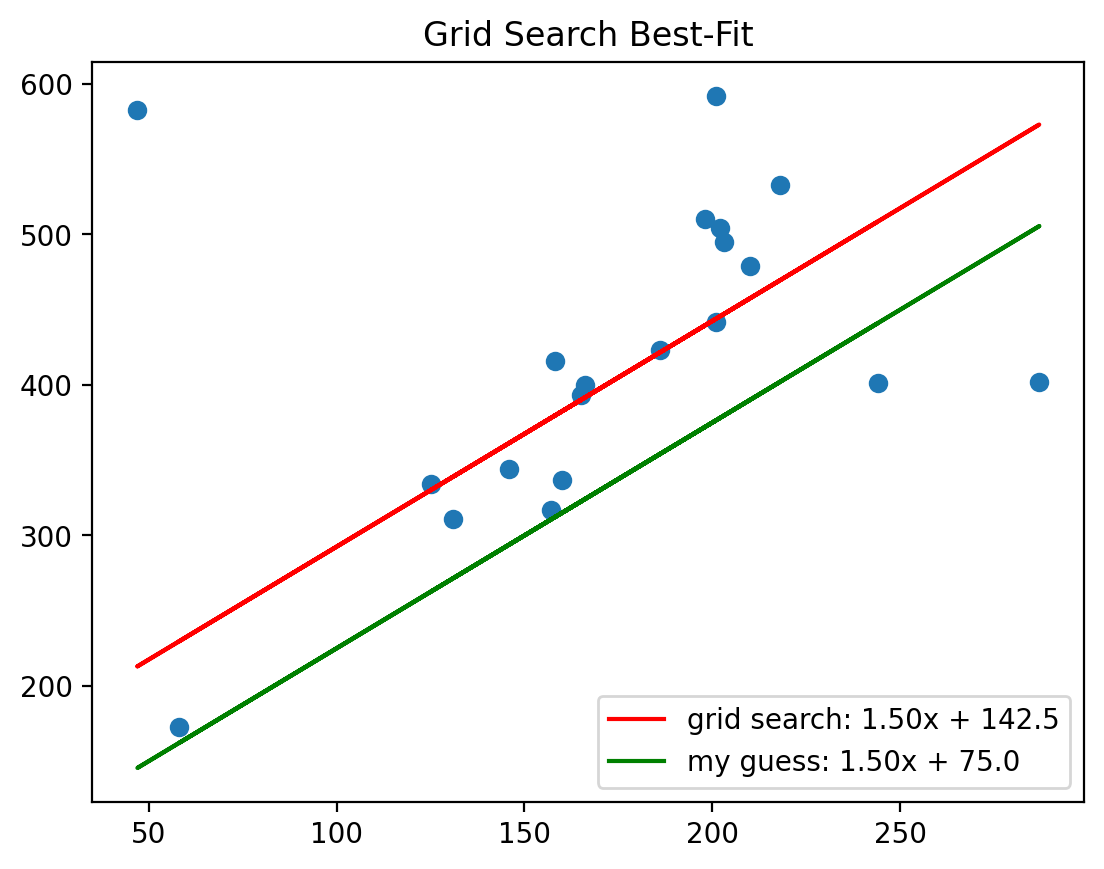

In [7]:
guess = (1.5,75)

# get the values from grid searching
best_parameter = grid_search(x,y,dy, guess)
[a,b] = best_parameter
yvals = a*x + b
yvals_guess = guess[0]*x + guess[1]

plt.scatter(x,y)
plt.plot(x,yvals,c='r',label="grid search: %.2fx + %.1f"%(a,b))
plt.plot(x,yvals_guess,c='g',label="my guess: %.2fx + %.1f"%guess)
plt.title("Grid Search Best-Fit")
plt.legend()
plt.show()

I did estimate my guess slope from 2 points on the plot, so it is a coincidence that the two fits match in terms of slope. The grid searched parameters fit better than my inital guess.

There are some strong outliers here that seem to be impacting the line fit still, so I will use sigma-clipping to reject these outliers.

In [8]:
# clip points that are n sigma away from the mean until the difference 
    # between the old and new moments are smaller than epsilon
    
def sigma_clip(x,y,dy):

    # saved values will go in here
    y_clipped = y
    x_clipped = x
    dy_clipped = dy
    
    
    y_sigma = y.std()
    y_mu = y.mean()
    while True:
        
        epsilon = 0.0001 # the difference threshold
        
        # find pts that are within 1.5sigma of the line and keep them
        idx = np.where(np.abs(y - (best_parameter[0]*x + best_parameter[1])) < 2*y_sigma)
        y_clipped = y[idx]
        x_clipped = x[idx]
        dy_clipped = dy[idx]
        
        sigma = y_clipped.std()
        mu = y_clipped.mean()
        
        # return if the difference is sufficiently small, otherwise keep clip on the clipped data
        if (np.abs(sigma-y_sigma) < epsilon) and (np.abs(mu-y_mu) < epsilon):
            break
        else:
            y = y_clipped
            x = x_clipped
            y_sigma = sigma
            y_mu = mu
            
            
    # Return the values that remain after clipping
    return x_clipped,y_clipped,dy_clipped 

Using the sigma clipping on the data.

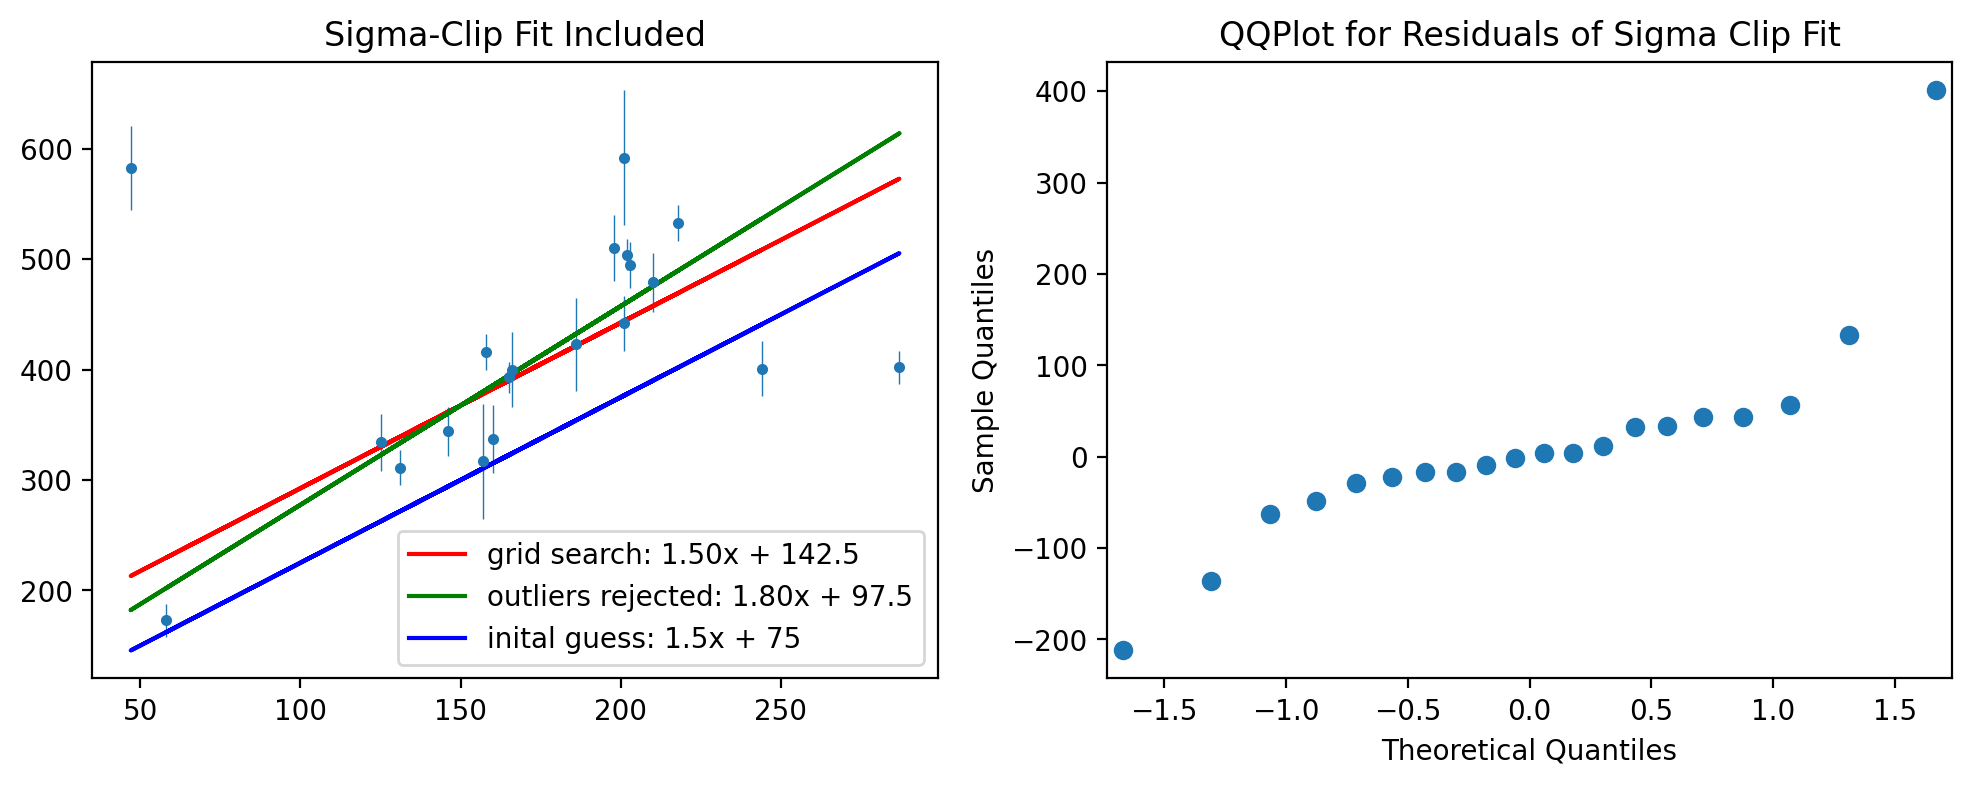

In [9]:
x_clip, y_clip, dy_clip = sigma_clip(x,y,dy)

# refittinng on the clipped data
best_parameter_clip = grid_search(x_clip,y_clip,dy_clip, (1.5,75))
[a_c, b_c]= best_parameter_clip
yvals_sigmaclip = a_c*x + b_c
yvals_guess = 1.5*x + 75

residuals_clip = y - yvals_sigmaclip

fig = plt.figure(figsize=(12,4))
ax = plt.subplot(121)
ax2 = plt.subplot(122)
ax.errorbar(x, y, yerr=dy, fmt='.', elinewidth=0.5)
ax.plot(x,yvals,c='r',label="grid search: %.2fx + %.1f"%(a,b))
ax.plot(x,yvals_sigmaclip,c='g', label="outliers rejected: %.2fx + %.1f"%(a_c,b_c))
ax.plot(x,yvals_guess,c='b', label="inital guess: %.1fx + %d"%(1.5,75))
ax.set_title("Sigma-Clip Fit Included")
ax.legend()

sm.qqplot(residuals_clip,ax=ax2)
ax2.set_title("QQPlot for Residuals of Sigma Clip Fit")
plt.show()

With the outliers rejected, the slope increases as expected. The outliers on the far left and right pull the line into a flatter slope, thus removing them better fits the data. Again, here the residuals on the QQ plot seems to be along the line a bit better. Before, there was an almost sinusodial wave along a line through the points, but now they fall a bit closer to a line.

Next, the data will be fit to a line using a similar method, but with a different cost function and it will use the scipy fucntion minimize instead of grid search. The Huber cost function is as follows:

$$ \rho(u)=   \left\{
\begin{array}{ll}
      \frac{1}{2}u^2 & |u| \leq \delta \\
      \delta(|u| - \frac{1}{2}\delta) & |u| > \delta \\
\end{array} 
\right.  $$

In [10]:
# computing the loss with the huber loss incorperated
    # almost the same as before, but using a new cost function
def huber_loss_squared(model_params, x, y, dy, delta):
    #delta = 0.2
    (a,b) = model_params
    def model(a,b,x):
        return a*x + b
    
    M_x = model(a,b,x)
    
    u = y - M_x
    cost = np.array([0.5*u**2 if np.abs(u) <= delta else delta*(np.abs(u) - 0.5*delta) for u in u])
    
    # sum the cost squared and incorperate the uncertainty
    return (cost * dy**-2).sum()

# minimize the huber loss squared
opt_param = scipy.optimize.fmin(huber_loss_squared, x0=(1,75), args=(x,y,dy,0.2))
opt_param

Optimization terminated successfully.
         Current function value: 0.487600
         Iterations: 63
         Function evaluations: 123


array([ 2.05513677, 53.91086368])

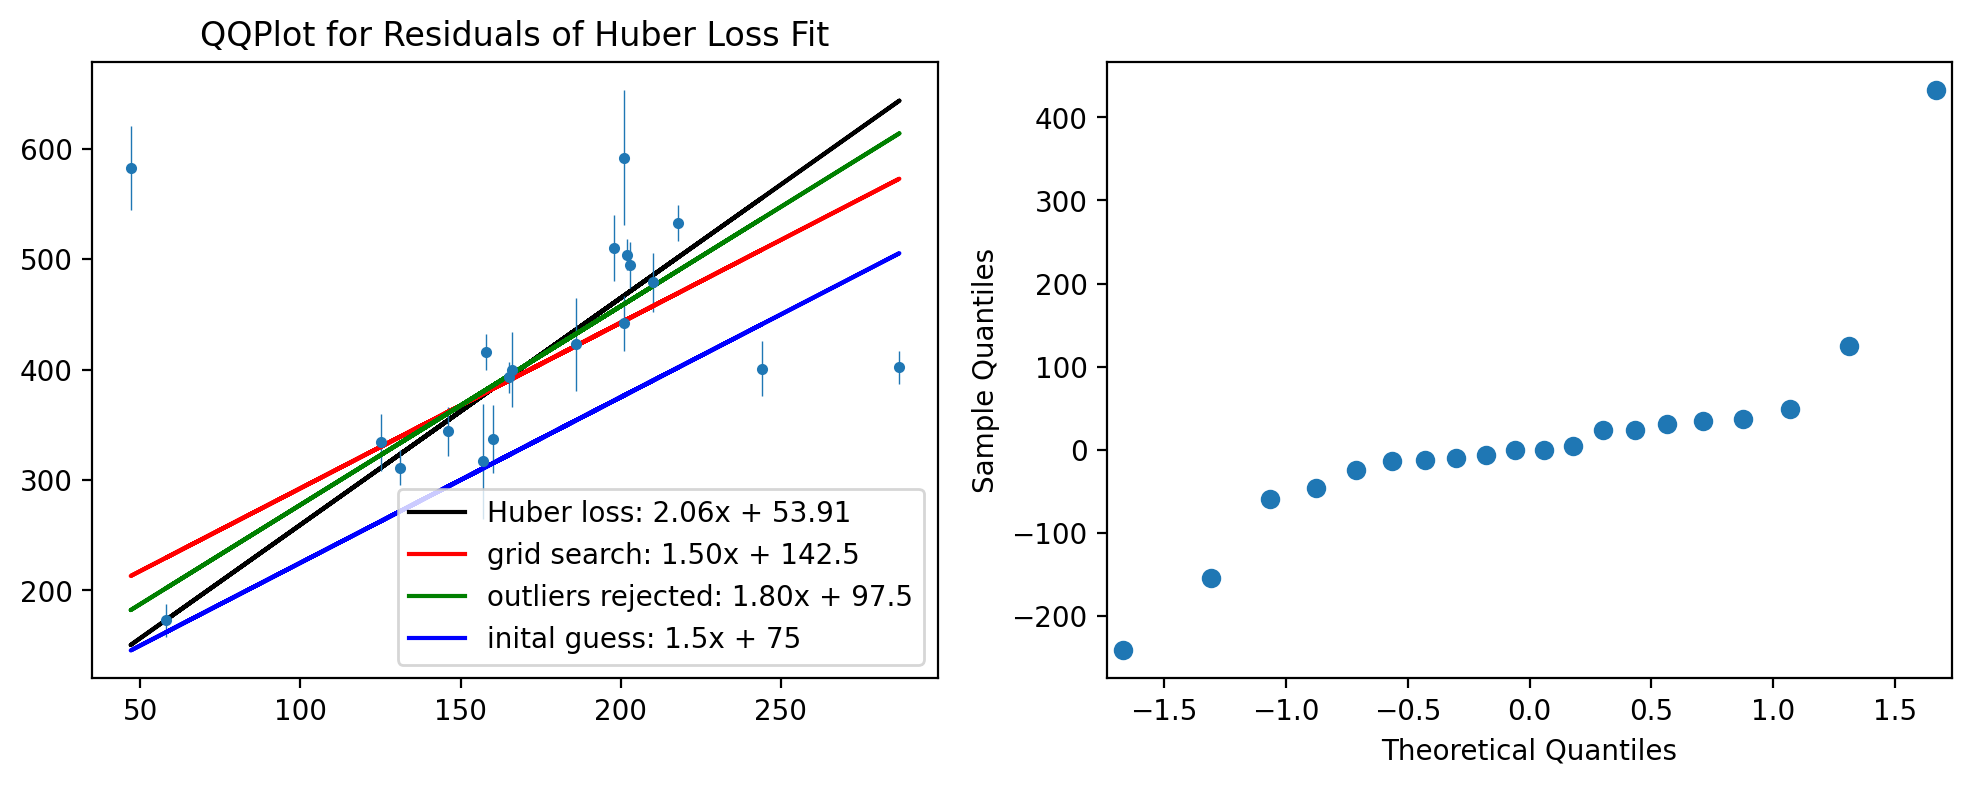

In [11]:
[a_h,b_h] = opt_param

yvals_h = a_h*x + b_h
residuals_h = y - yvals_h

fig = plt.figure(figsize=(12,4))
ax = plt.subplot(121)
ax2 = plt.subplot(122)

ax.plot(x,yvals_h,c='black', label="Huber loss: %.2fx + %.2f"%(a_h,b_h))
ax.set_title("Huber Loss Fit Included")
ax.errorbar(x, y, yerr=dy, fmt='.', elinewidth=0.5)
ax.plot(x,yvals,c='r',label="grid search: %.2fx + %.1f"%(a,b))
ax.plot(x,yvals_sigmaclip,c='g', label="outliers rejected: %.2fx + %.1f"%(a_c,b_c))
ax.plot(x,yvals_guess,c='b', label="inital guess: %.1fx + %d"%(1.5,75))
ax.legend()

sm.qqplot(residuals_h, ax=ax2)
ax2.set_title("QQPlot for Residuals of Huber Loss Fit")

plt.show()

The Huber loss fit is similar to the sigma clipping. Visually it fits better on the plot, and this is likely related to the minimizing being done with scipy instead of the flat grid. Also, the QQ plot is similar to that of the sigma clipped residuals. 

## Problem 2

The demo data set for this part is the Wesenheit index of the OGLE-III fundamental-mode and first overtone classical Cepheids. 

These stars are awesome because you can use them to measure distances. Here's a nice [youtube video](https://www.youtube.com/watch?v=iyisAjHdhas) on these stars.

You'll try to estimate their period-luminosity relationship. 

The Wesenheit index is defined as `W = I - 1.55(V - I)`, and its main advantage over using simply the I or V photometry is that it is insensitive to extinction. It is denoted by 'W' among the data columns. 

Other columns are 'name', the identifier of the star; 'RA0' (in decimal hours) and 'Decl0' (in decimal degrees), celestial coordinates; 'Mode', the mode of the Cepheid ('F' indicates fundamental-mode, '1' indicates first overtone star); 'Cloud', indicating which Magellanic Cloud the star belongs to; 'logP1', the base-10 logarithm of the period in days; 'VI', the colour V-I.


Split the data into LMC and SMC, and then again by mode F and 1, and plot the `W` on the y-axis vs `log(P1)` on x.
Fit or estimate straight lines to each of the four samples using your solution to Problem 1. (10 pts)

Compute the residuals of each sample to it's respective line. Do these residuals look like a normal distribution? If not, speculate on why (WATCH THE YOUTUBE VIDEO!) (10 pts)

Plot the residuals color coded by if they are positive or negative vs RA and Dec (just like a Hess diagram in Problem 1). (15 pts)

Finally, plot the residuals against the fitted `W` values, and just to anticipate the next homework assignment, also plot `log(P1) vs V-I`. Comment on what you are seeing. (15 pts)

In [13]:
import pandas as pd

# preview the data
cepheids = pd.read_csv('Cepheids.csv')
cepheids[:5]

,name,RA0,Decl0,Mode,Cloud,W,logP1,VI
0,OGLE-LMC-CEP-0002,4.529733,-69.81933,F,LMC,14.52500,0.493893,0.740
1,OGLE-LMC-CEP-0005,4.592089,-69.73497,F,LMC,13.49540,0.749122,0.752
2,OGLE-LMC-CEP-0012,4.630203,-67.21442,F,LMC,14.54210,0.424912,0.598
3,OGLE-LMC-CEP-0016,4.642367,-67.64631,F,LMC,12.03300,1.021456,1.080
4,OGLE-LMC-CEP-0017,4.649119,-69.68839,F,LMC,14.34215,0.565524,0.647


In [14]:
# split the data
LMC_F = cepheids[(cepheids['Cloud']=='LMC') & (cepheids['Mode']=='F')]
LMC_1 = cepheids[(cepheids['Cloud']=='LMC') & (cepheids['Mode']=='1')]
SMC_F = cepheids[(cepheids['Cloud']=='SMC') & (cepheids['Mode']=='F')]
SMC_1 = cepheids[(cepheids['Cloud']=='SMC') & (cepheids['Mode']=='1')]

#assert(len(cepheids) == len(LMC_F)+len(SMC_F)+len(LMC_1)+len(SMC_1))

In [15]:
titles = []
datas = []
for c in ['LMC', 'SMC']:
    for m in ['F', '1']:
        titles.append(c+', '+m)
        datas.append(cepheids[(cepheids['Cloud']==c) & (cepheids['Mode']==m)])

Using the Huber-loss method for fitting lines to these cepheids.

Optimization terminated successfully.
         Current function value: 11.312888
         Iterations: 34
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: 8.296653
         Iterations: 49
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: 36.316879
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: 24.766247
         Iterations: 44
         Function evaluations: 84


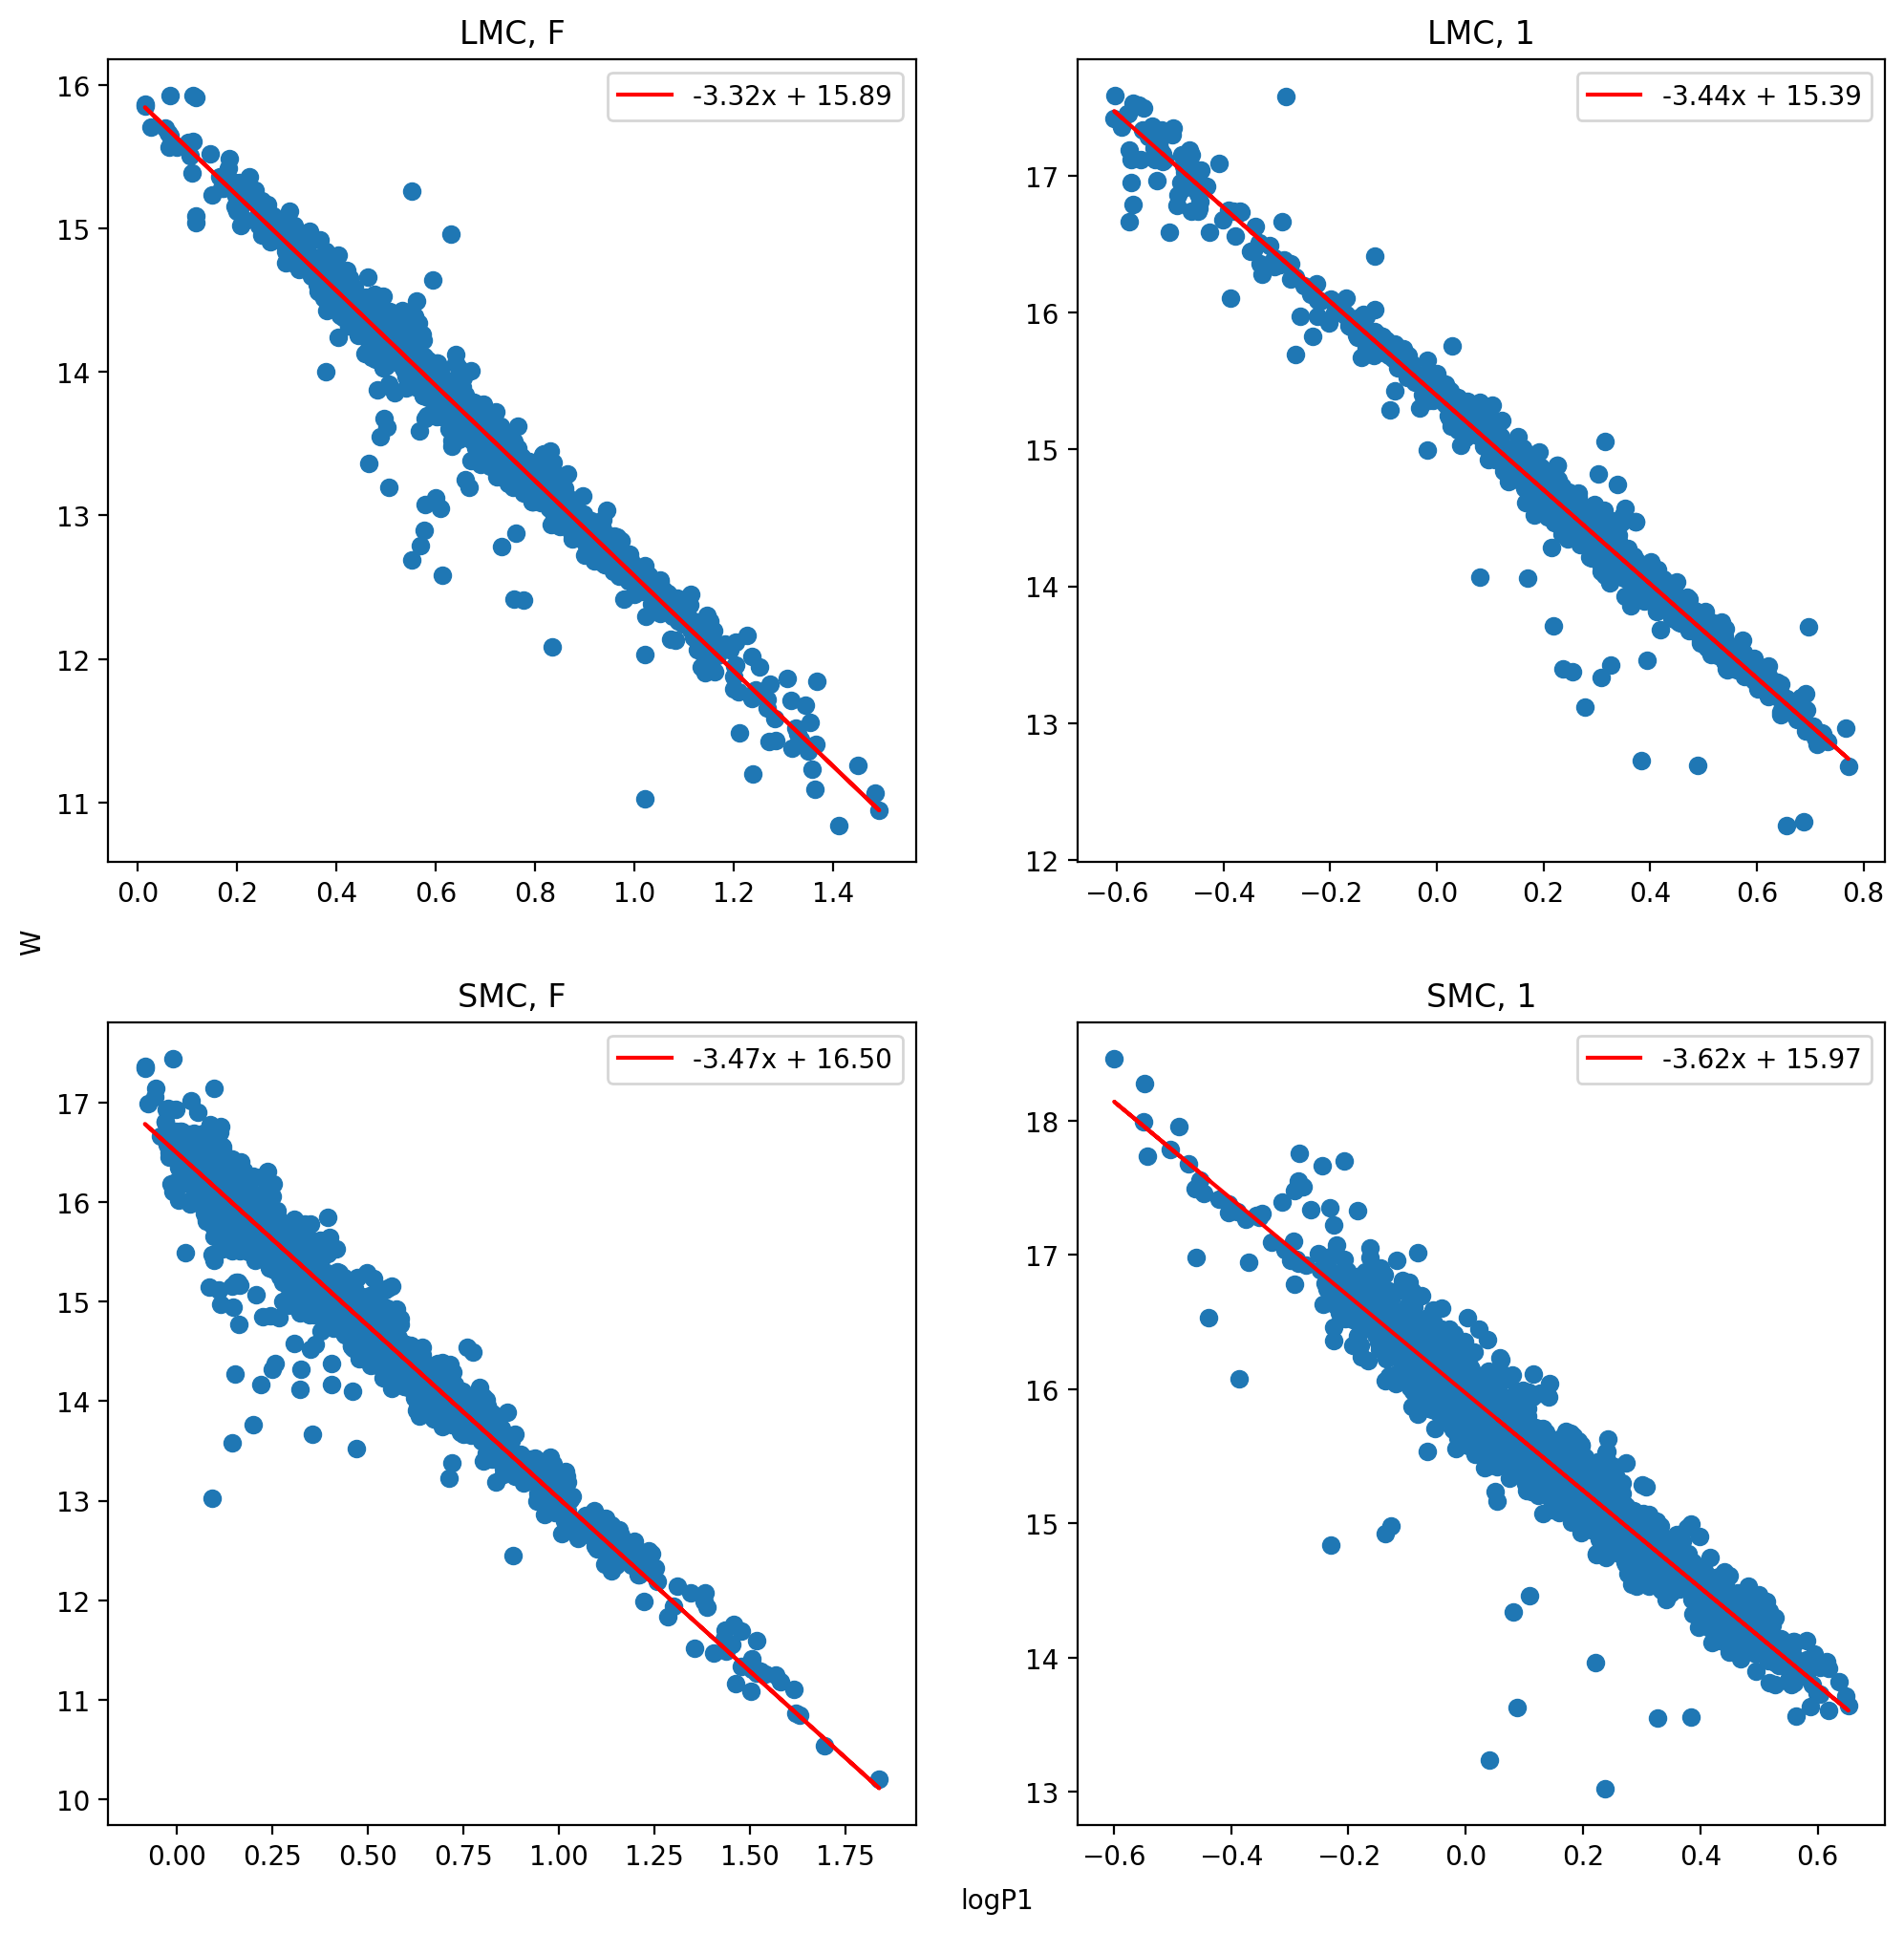

In [37]:
plt.rc('axes', labelsize=10)
fig = plt.figure(figsize=(12,12))
ax_l = fig.add_subplot(111, frame_on=False)
ax_l.set_xlabel("logP1", labelpad=20)
ax_l.set_ylabel("W", labelpad=20)
ax_l.set_yticks([])
ax_l.set_xticks([])
guess = [(-3.6, 16), (-3.75,18), (-4,18), (-3.5,19)]
residuals = []
for i, d in enumerate(datas):
    ax = fig.add_subplot(2,2,i+1)
    ax.set_title(titles[i])
    x = d['logP1']
    y = d['W']
    dy = np.array([1.0]*len(y)) # make the weight (by uncertainty) all equal
    ax.scatter(x, y)
    [a,b] = scipy.optimize.fmin(huber_loss_squared, x0=guess[i], args=(x,y,dy,0.2))
    yvals = a*x + b
    ax.plot(x,yvals, c='r', label="%.2fx + %.2f"%(a,b))
    residuals.append(y - yvals)
    plt.legend()
#fig.set_ylabel()

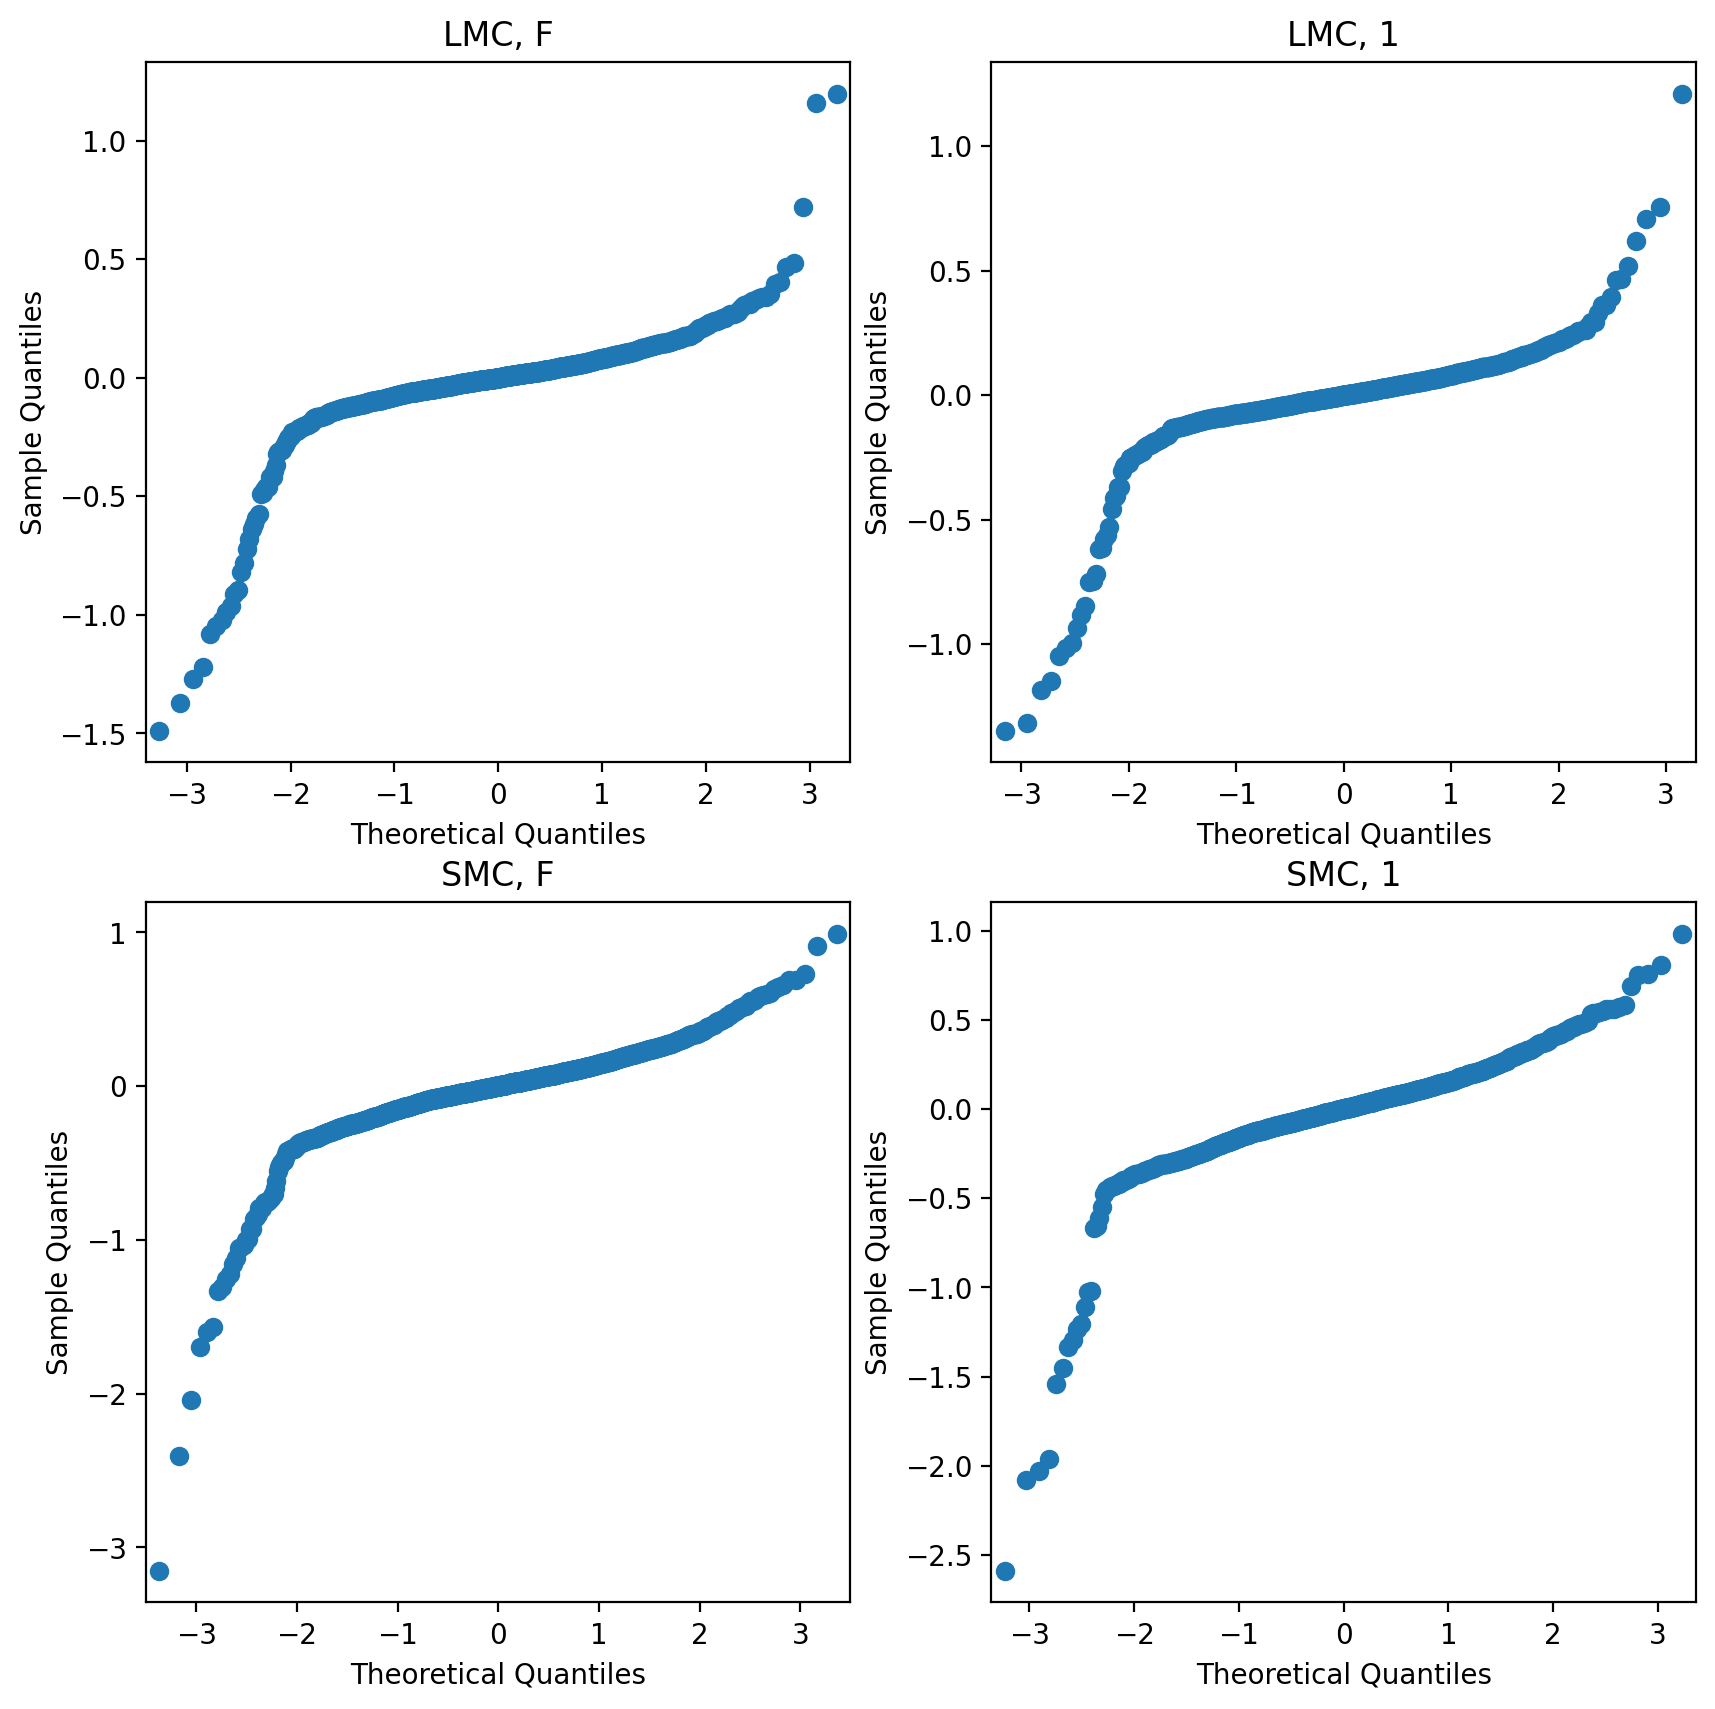

In [17]:
fig = plt.figure(figsize=(10,10))
for i, r in enumerate(residuals):
    ax = fig.add_subplot(2,2,i+1)
    ax.set_title(titles[i])
    sm.qqplot(r,ax=ax)

These residuals do not seem to follow a normal distribution, therefore the measurements of W fail to be independant and/or identically distributed. Since measurement of one value doesn't impact the telescope measuring another star, these are probably independant. The Ws fail to be identically distributed. Another problem could be the lack of uncertainty in the measurement of the luminosity. Objects that appear fainter in the sky are more difficult to measure accurately. Since there was no listed uncertainty, the model considers each point to be equally weighted, which is most likely incorrect.

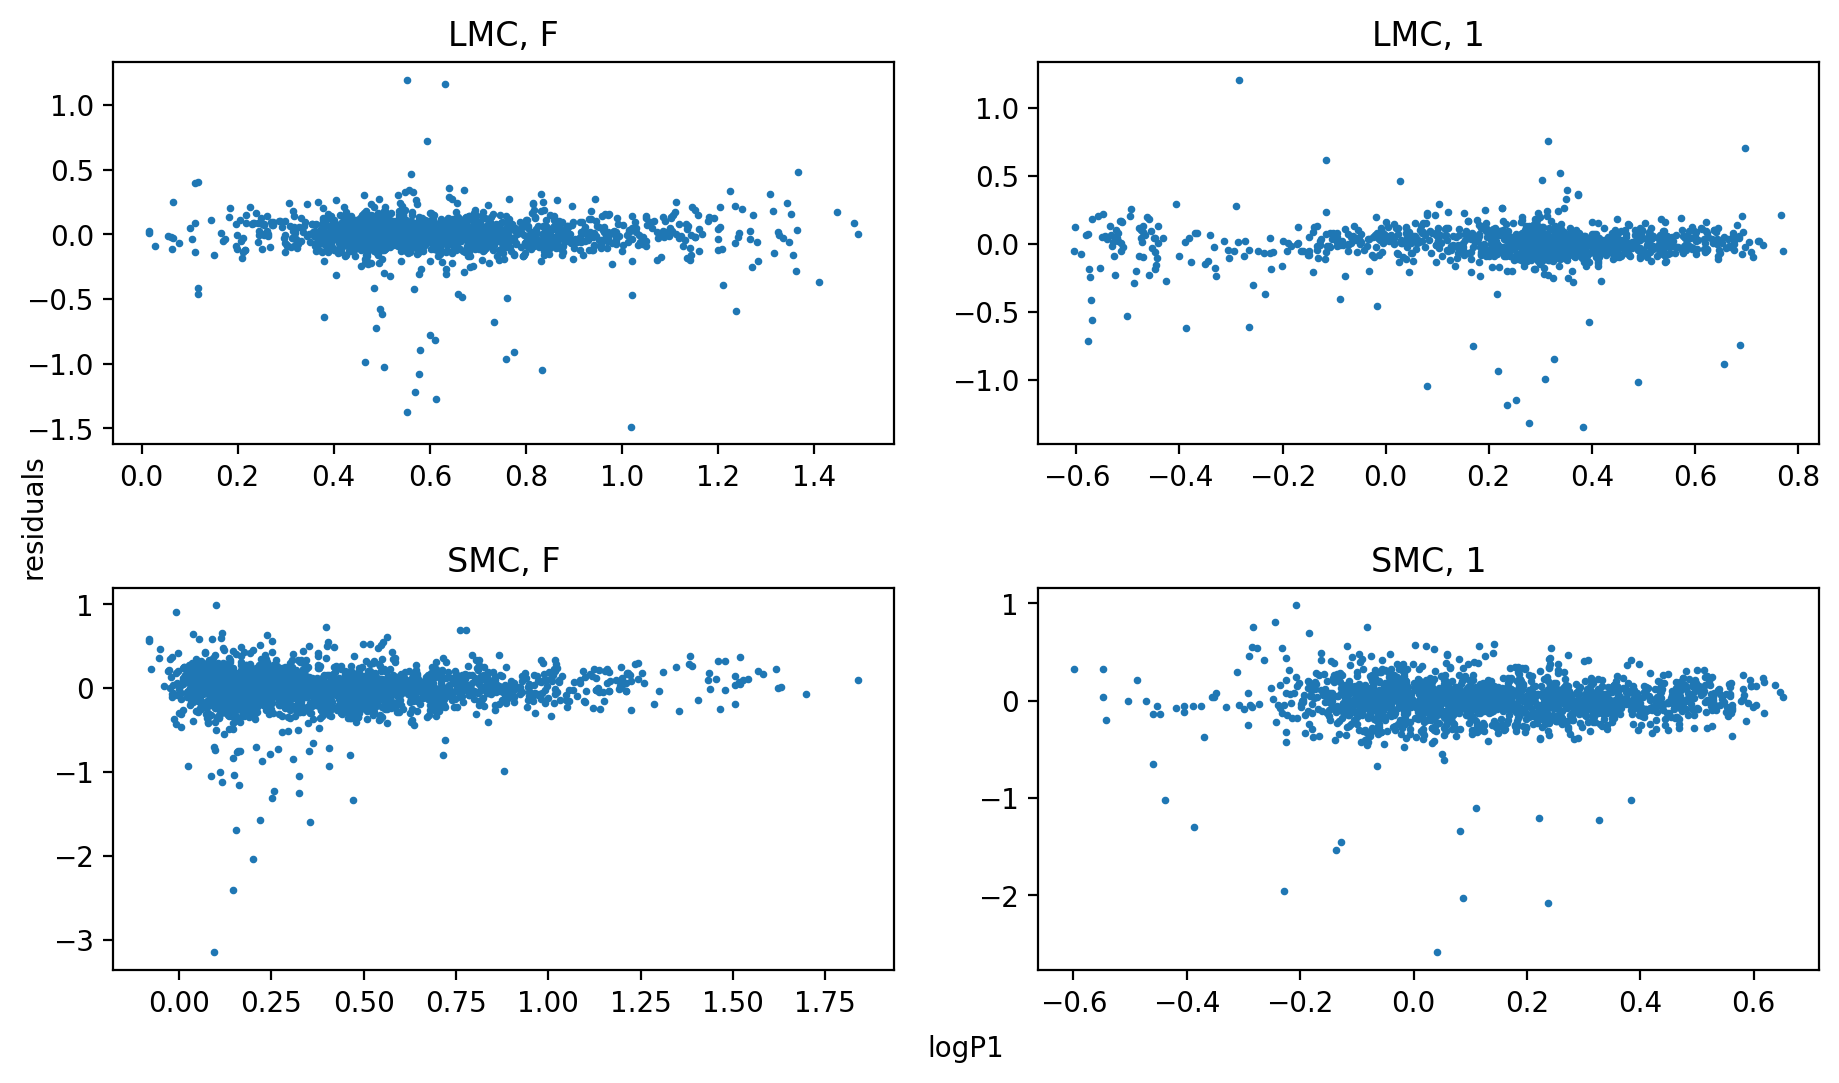

In [35]:
# demonstrating the lack of uniform residuals
plt.rc('axes', labelsize=10)
fig = plt.figure(figsize=(10,6))
ax_l = fig.add_subplot(111, frame_on=False)
ax_l.set_xlabel("logP1", labelpad=20)
ax_l.set_ylabel("residuals", labelpad=20)
ax_l.set_yticks([])
ax_l.set_xticks([])
for i, d in enumerate(datas):
    ax = fig.add_subplot(2,2,i+1)
    
    x = d['logP1']
    y = residuals[i]
    
    
    # color residuals - green for if the residual is positive, red otherwise
    ax.set_title(titles[i])
    ax.scatter(x, y, s=3)
fig.tight_layout(pad=2)

These residuals lack constant variance (the range of residuals is not constant across all logP1), which means the data is not homoscedastic.

The Hess plot:

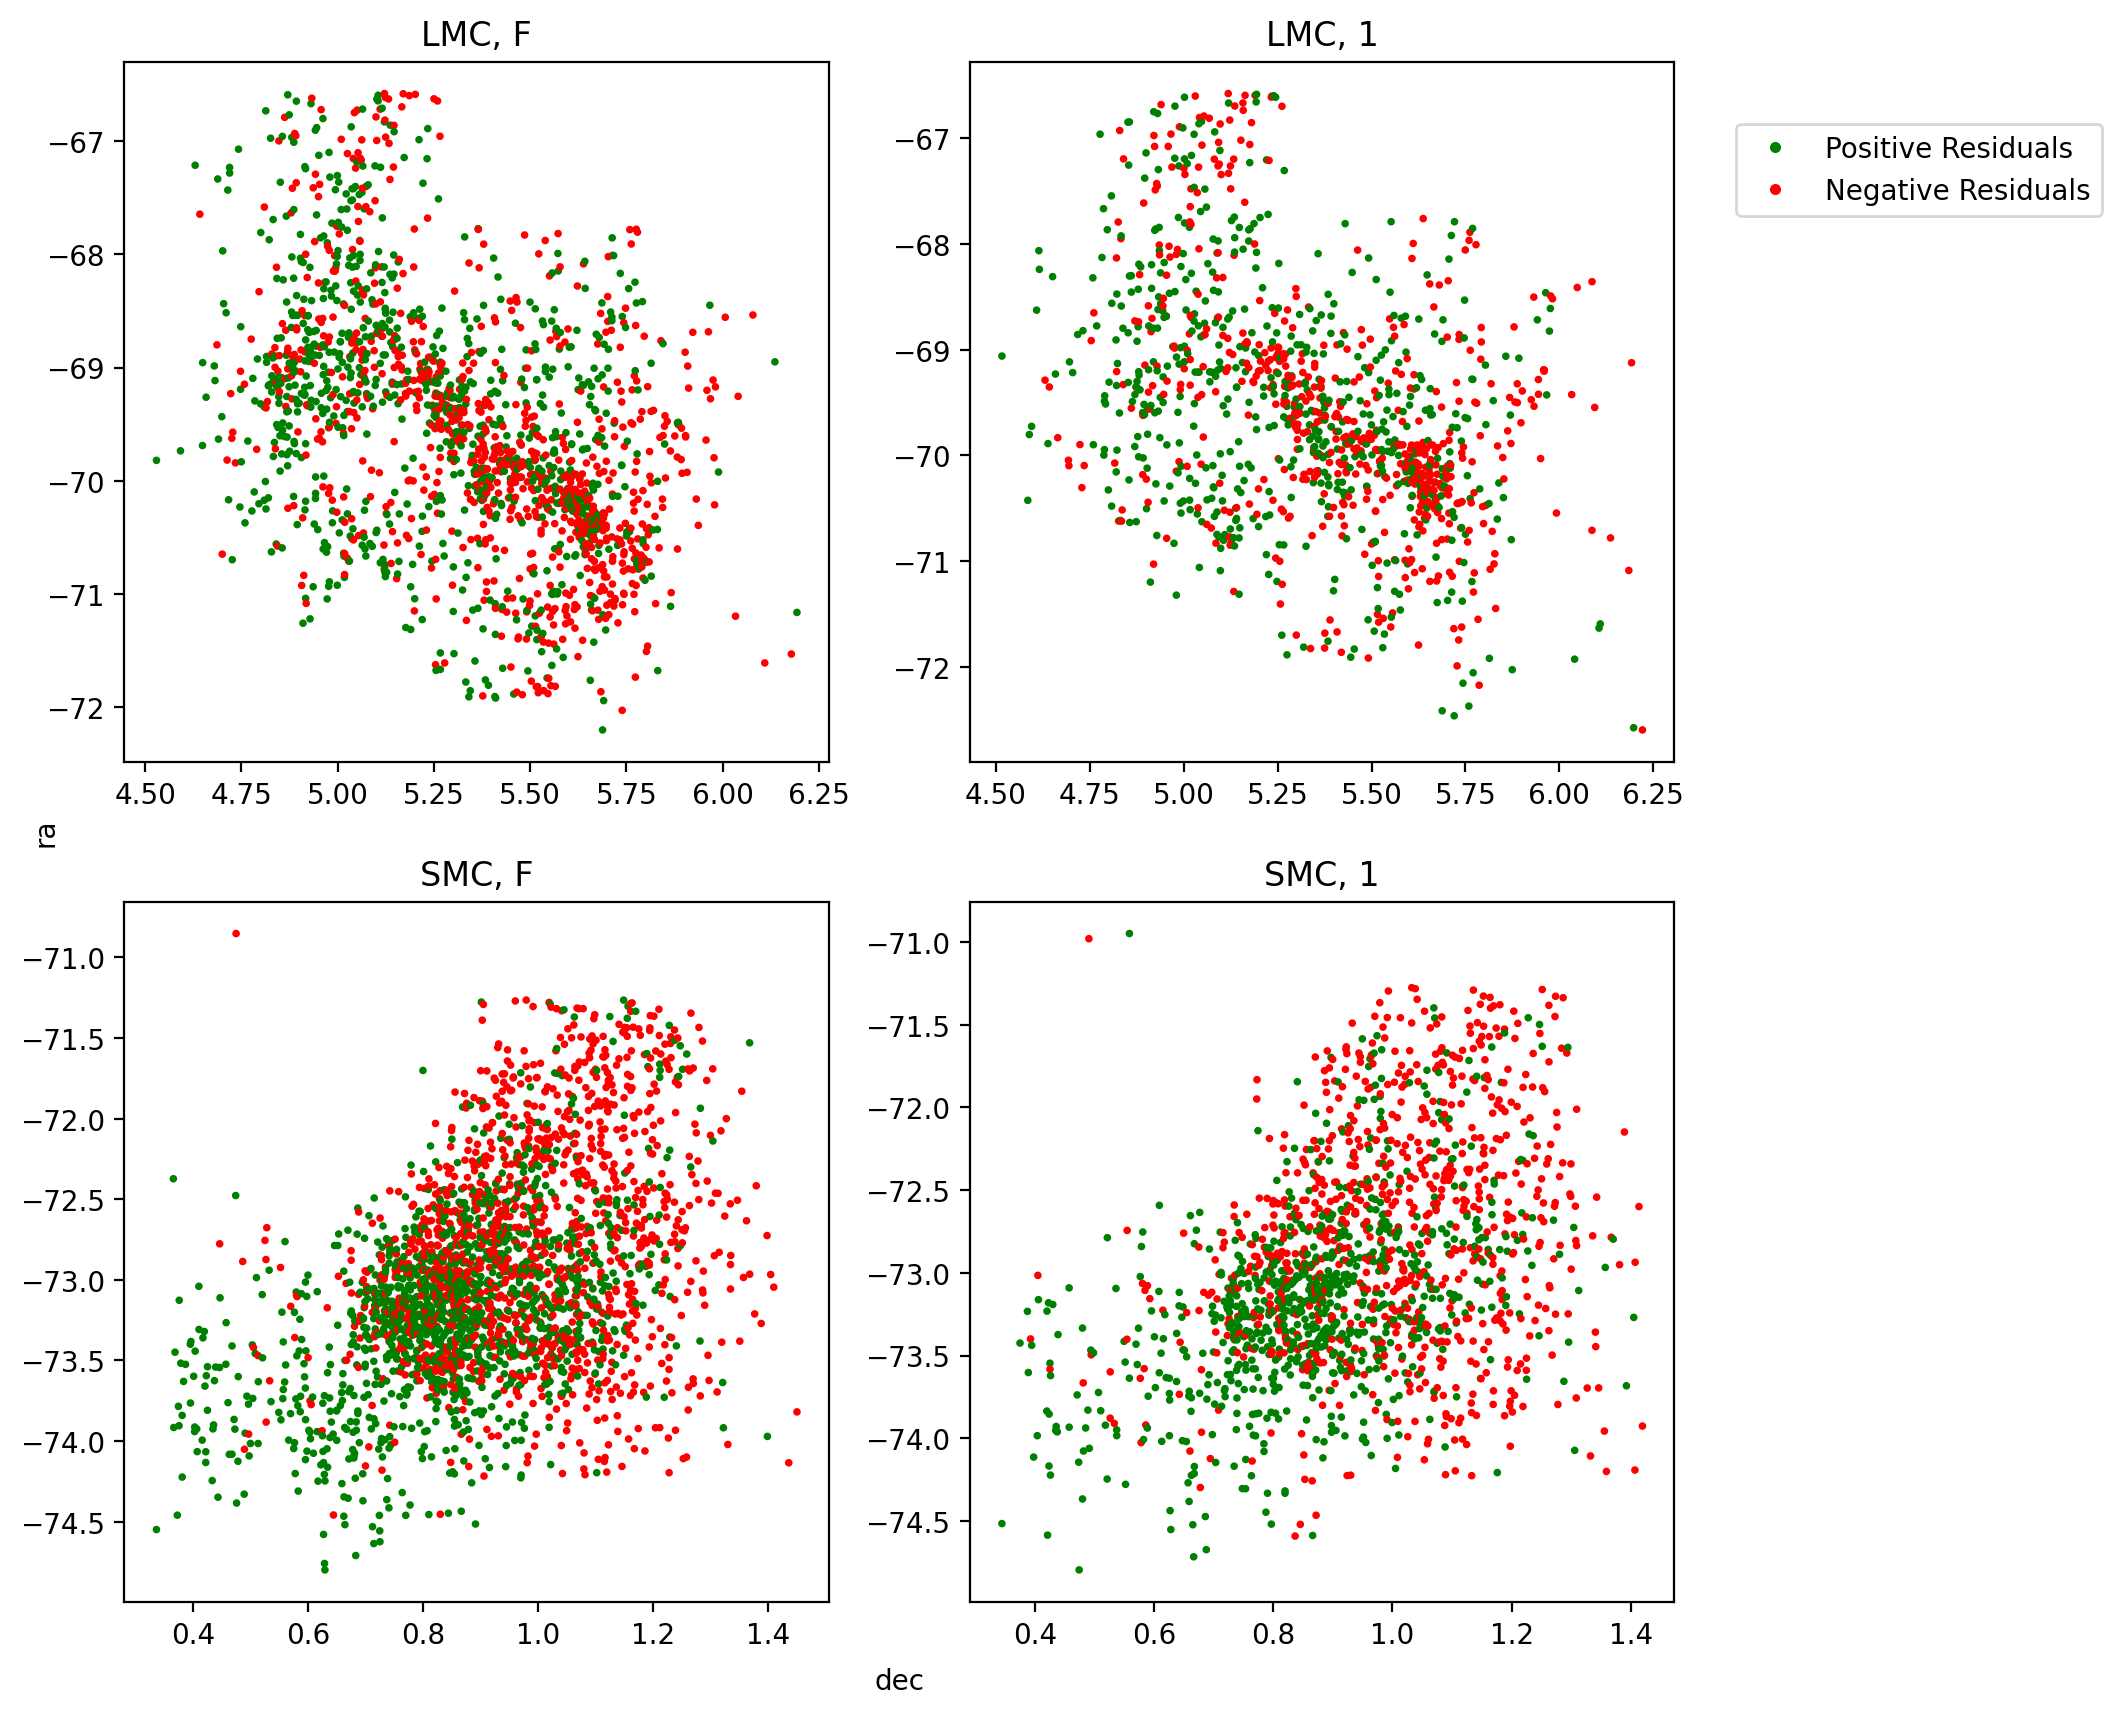

In [38]:
from matplotlib.lines import Line2D # to add in the label

plt.rc('axes', labelsize=10)
fig = plt.figure(figsize=(10,10))
ax_l = fig.add_subplot(111, frame_on=False)
ax_l.set_xlabel("dec",labelpad=20)
ax_l.set_ylabel("ra",labelpad=20)
ax_l.set_yticks([])
ax_l.set_xticks([])

# add specific label
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Positive Residuals',
                          markerfacecolor='g', markersize=5),
                      Line2D([0], [0], marker='o', color='w', label='Negative Residuals',
                          markerfacecolor='r', markersize=5)]
ax_l.legend(handles=legend_elements, loc=(1.04, 0.9))

for i, d in enumerate(datas):
    ax = fig.add_subplot(2,2,i+1)
    
    ra = d['RA0']
    dec = d['Decl0']
    r = residuals[i]
    
    # color residuals - green for if the residual is positive, red otherwise
    col = np.array(['g' if r_val > 0 else 'r' for r_val in r])
    
    
    ax.set_title(titles[i])
    ax.scatter(ra, dec, c=col, s=3) 

In the LMC, there seems to be a diagonal shaped cluster for cepheids with negative residuals and less structure for those with positive residuals.

In the SMC, it appears that there are 2 regions in the sky where the residuals are positive versus negative. The two regions over lap, but it seems there are more positive residuals in the lower left and more negative towards the top right.

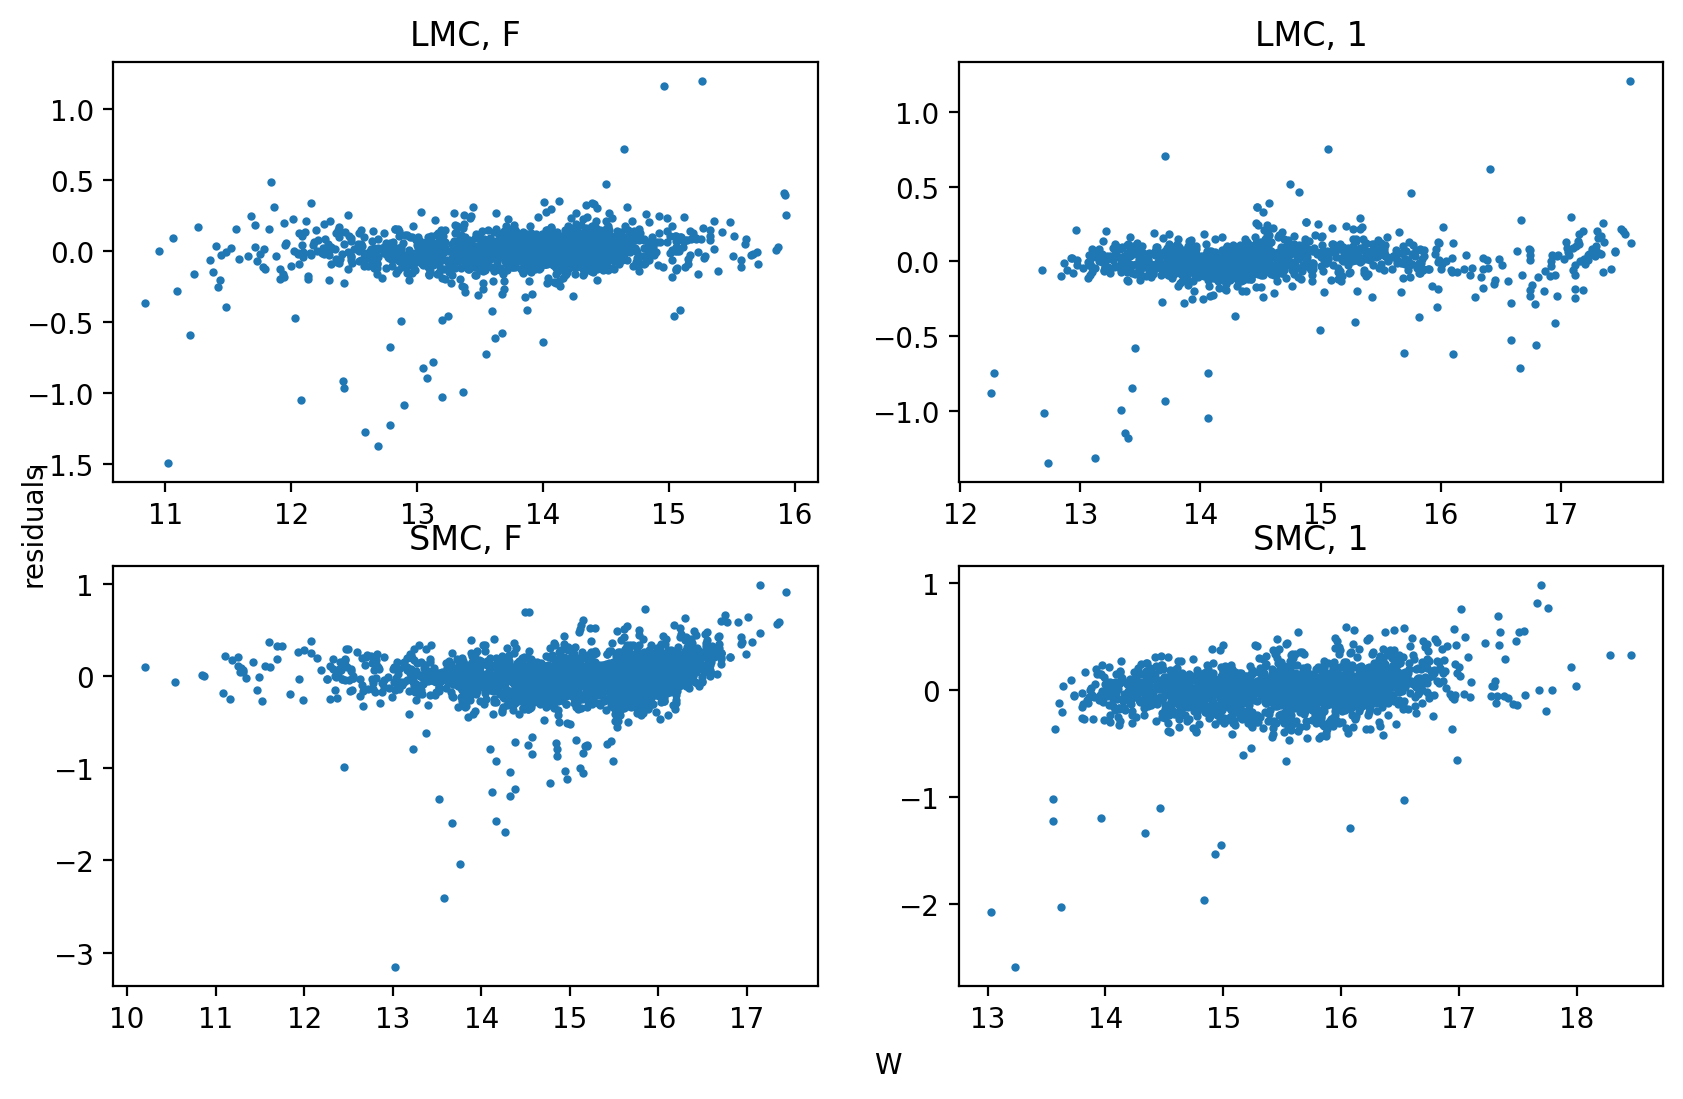

In [39]:
plt.rc('axes', labelsize=10)
fig = plt.figure(figsize=(10, 6))
ax_l = fig.add_subplot(111, frame_on=False)
ax_l.set_xlabel("W",labelpad=20)
ax_l.set_ylabel("residuals",labelpad=20)
ax_l.set_yticks([])
ax_l.set_xticks([])
for i, d in enumerate(datas):
    ax = fig.add_subplot(2,2,i+1)
    
    w = d['W']
    r = residuals[i]
    
    ax.set_title(titles[i])
    ax.scatter(w, r, s=4) # residuals vs W

There is a general cluster of points that has no difference from the model and is independant of W; however, the width around 0 residual is not uniform, suggesting that this data is not homoscedastic.

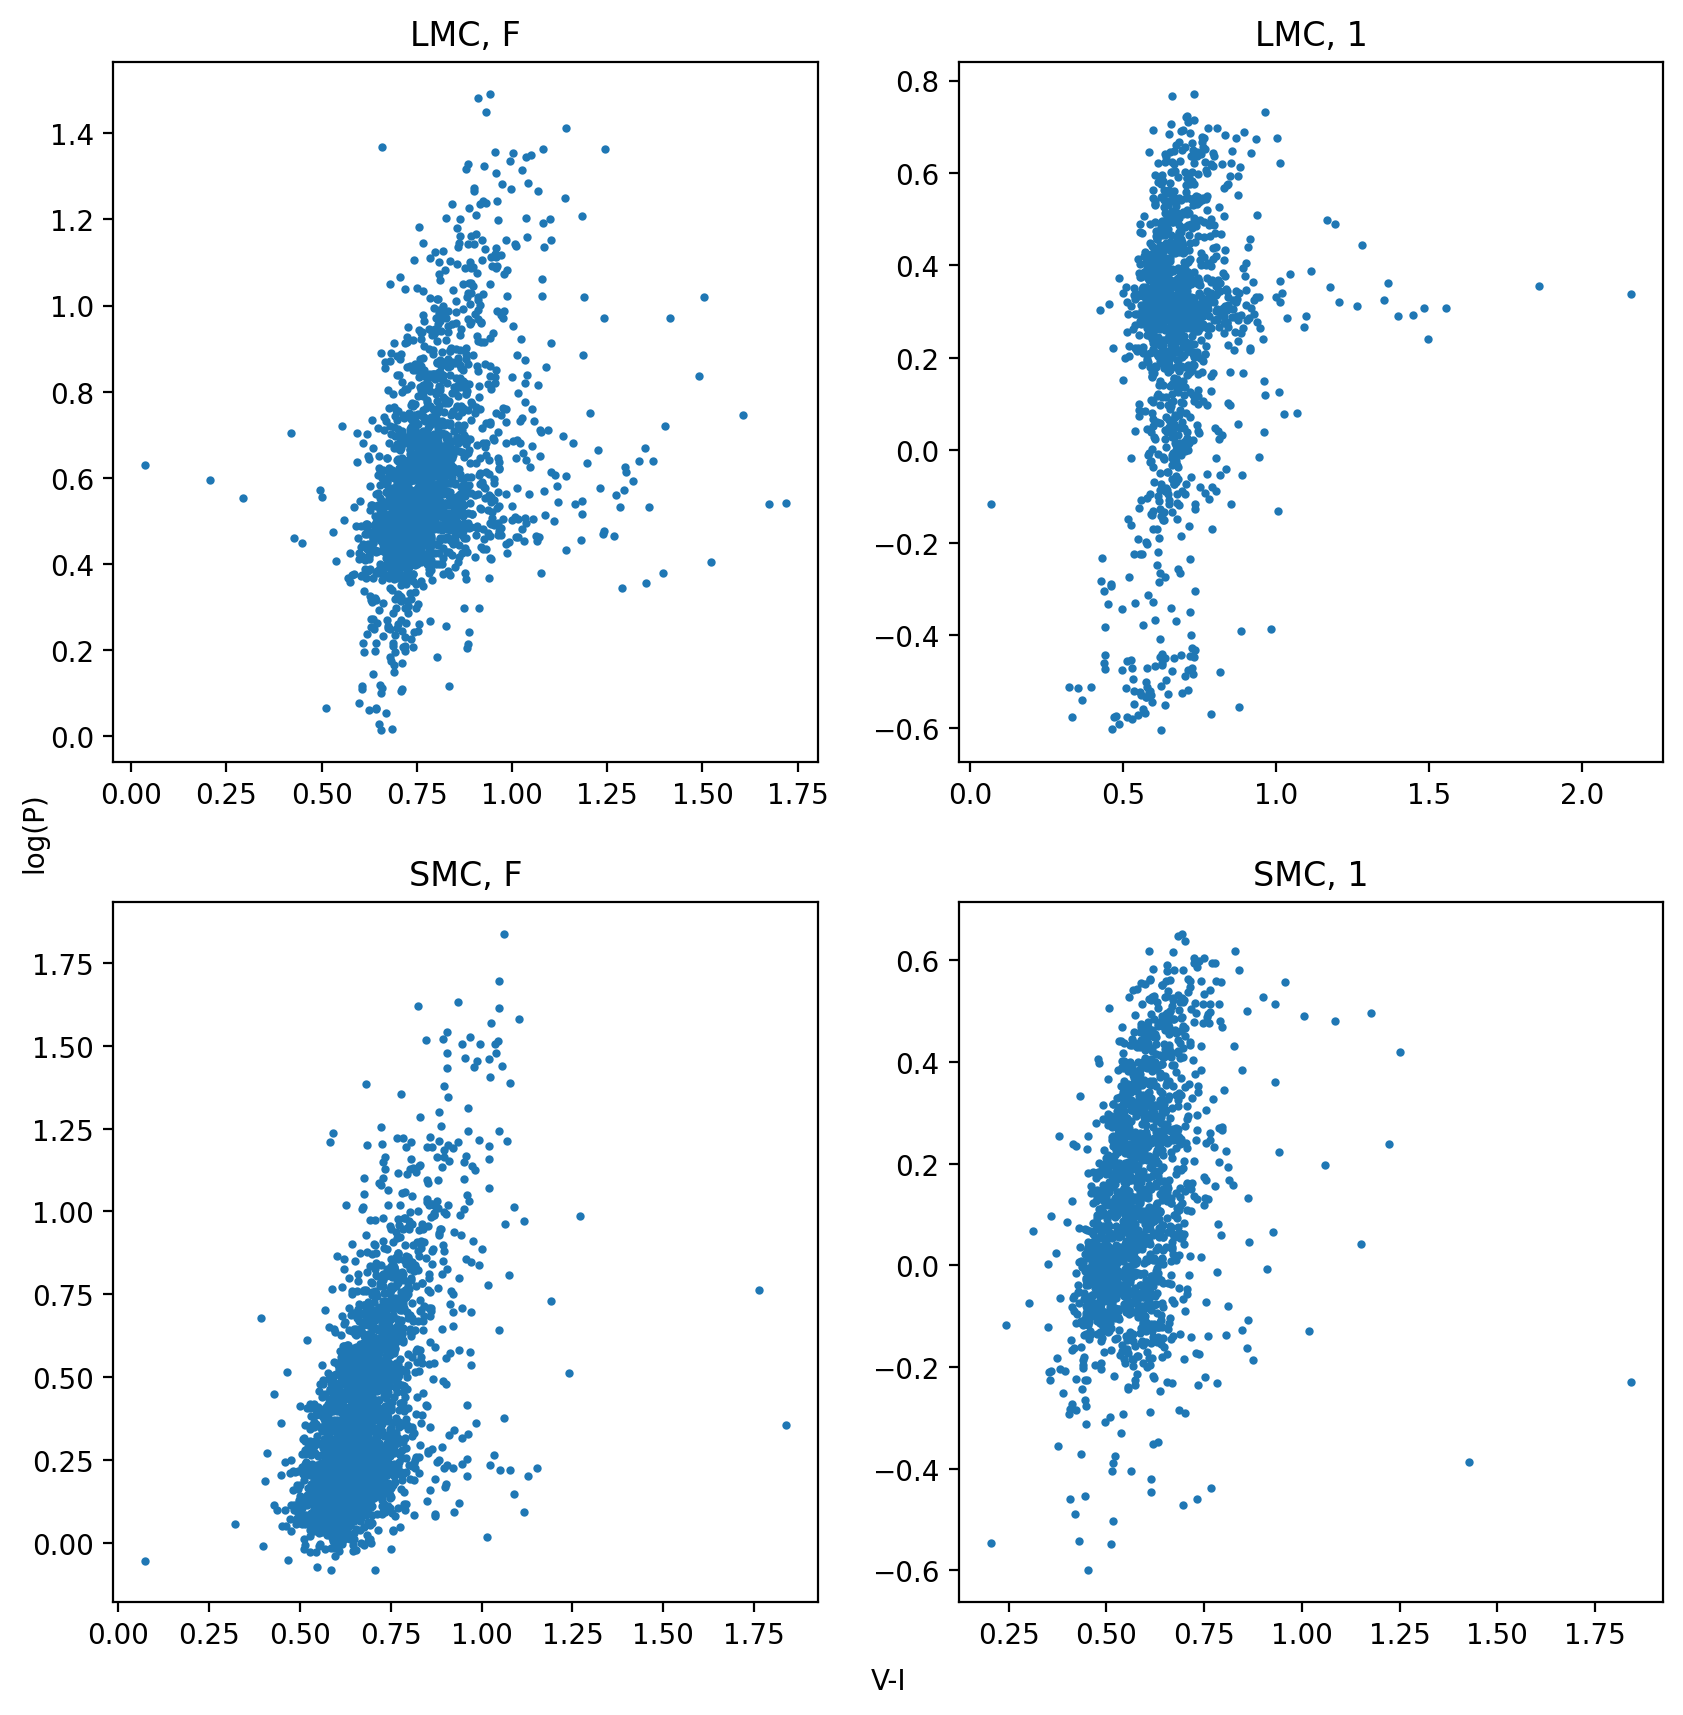

In [40]:
plt.rc('axes', labelsize=10)
fig = plt.figure(figsize=(10,10))
ax_l = fig.add_subplot(111, frame_on=False)
ax_l.set_ylabel("log(P)",labelpad=20)
ax_l.set_xlabel("V-I",labelpad=20)
ax_l.set_yticks([])
ax_l.set_xticks([])
for i, d in enumerate(datas):
    ax = fig.add_subplot(2,2,i+1)
    
    logP = d['logP1']
    vi = d['VI']
    
    ax.set_title(titles[i])
    ax.scatter(vi, logP, s=4) # logP vs VI

There seems to be general clustering of Cepheids in regions of the plot, but there is some width, so a linear relation does not seem like it would completely describe this. Additionally, the general trend is quite vertical, so for a given $VI$ color, there is a range of possible $\log P1$.
